# Methods

Starting a new notebook to address many of the thoughts in this comment: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413. 

This will likely include work to address:
- different ways to deal with boundaries when filtering
- a closer look into spice anomaly

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import funcs

In [2]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

### Idealized Profiles

This example is from Dhruv's notebooks over winter break (and more specifically the density-spice notebook).

In [3]:
L = 1000 # let's say units of m 
N = 512

alpha = 0
N2, z, dz = funcs.random_phase_power_law_function(alpha, N, L)
S, z, dz  = funcs.random_phase_power_law_function(3, N, L)
S = S/S.std()+36.5
N2 = (N2 + N2.max()+1) * 2e-4
rho = np.cumsum(N2) + 1020

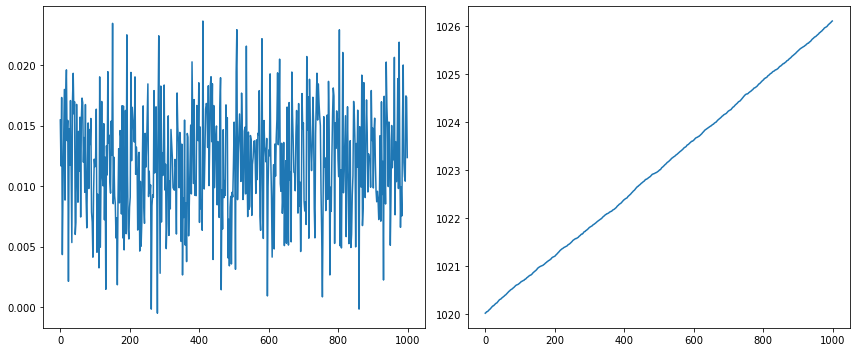

In [4]:
plt.figure(figsize= (12, 5))
plt.subplot(121)
plt.plot(z, N2)

plt.subplot(122)
plt.plot(z, rho)

plt.tight_layout()

In [5]:
T, _ = gsw.CT_from_rho(rho, S, 0)

spice = gsw.spiciness0(S, T)

In [6]:
profile = xr.Dataset(data_vars=dict(
                        CT=(['depth'],T),
                        SA=(['depth'],S),
                        SIG=(['depth'],rho),
                        SPICE=(['depth'], spice)
                        ),
                    coords=dict(
                        depth=z,)
                        )

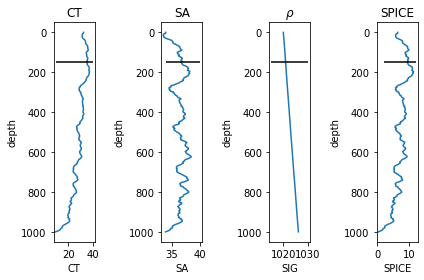

In [7]:
plt.subplot(141)
profile.CT.plot(y='depth')
plt.hlines(150,10,40,color='k')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
profile.SA.plot(y='depth')
plt.hlines(150,34,40,color='k')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
profile.SIG.plot(y='depth')
plt.hlines(150,1015,1030,color='k')
plt.gca().invert_yaxis()
plt.title(r'$\rho$')

plt.subplot(144)
profile.SPICE.plot(y='depth')
plt.hlines(150,2,12,color='k')
plt.gca().invert_yaxis()
plt.title('SPICE')


plt.tight_layout()

### Boundaries

A few different approaches are possible here, a few of them are noted below:
- filter the whole profile
- filter the whole profile, then mask both boundaries (based on the filter scale)
- filter the whole profile, then mask the upper boundary (based on the mixed layer depth)
- select the profile below the mixed layer, then filter

First up, I'll need to get a handle on mixed layer datasets. Looking at the netcdf file with MLD for every argo profile here: http://mixedlayer.ucsd.edu/. It's a large file though (300+MB) so I have to figure out the best way to upload it here.

In [8]:
part_min = 100
part_max = 1000-100

CT_filt_whole = ff.get_filt_prof(profile.CT,                                                             100,dim2='depth')
CT_filt_part  = ff.get_filt_prof(profile.CT.where(profile.depth>part_min).where(profile.depth<part_max), 100,dim2='depth')

In [9]:
filt = xr.Dataset(data_vars=dict(
                        CT=(['depth'],T),
                        SA=(['depth'],S),
                        SIG=(['depth'],rho),
                        SPICE=(['depth'], spice),
                        CT_whole=(['depth'], CT_filt_whole),
                        CT_part = (['depth'], CT_filt_part)
                        ),
                    coords=dict(
                        depth=z,)
                        )

In [10]:
filt = filt.assign(CT_whole_mask = filt.CT_whole.where(filt.depth>part_min).where(filt.depth<part_max))
filt = filt.assign(CT_part_mask = filt.CT_part.where(filt.depth>part_min+100).where(filt.depth<part_max-100))
filt

<xarray.Dataset>
Dimensions:        (depth: 512)
Coordinates:
  * depth          (depth) float64 0.0 1.953 3.906 5.859 ... 994.1 996.1 998.0
Data variables:
    CT             (depth) float64 32.46 32.42 32.39 32.04 ... 11.25 10.21 9.598
    SA             (depth) float64 33.99 33.98 33.99 33.83 ... 34.32 34.1 33.98
    SIG            (depth) float64 1.02e+03 1.02e+03 ... 1.026e+03 1.026e+03
    SPICE          (depth) float64 6.354 6.339 6.335 ... 0.8743 0.5222 0.3296
    CT_whole       (depth) float64 32.38 32.39 32.41 32.44 ... 12.65 12.44 12.23
    CT_part        (depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    CT_whole_mask  (depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    CT_part_mask   (depth) float64 nan nan nan nan nan ... nan nan nan nan nan

Text(0.5, 1.0, 'Filtered CT Profiles')

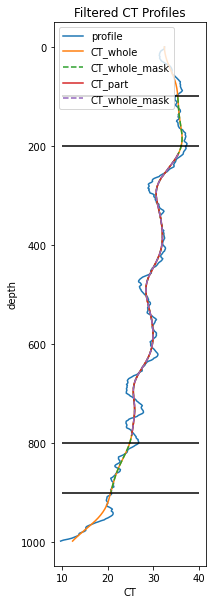

In [11]:
plt.figure(figsize=(6,10))
plt.subplot(122)
profile.CT.plot(y='depth',label='profile')
filt.CT_whole.plot(y='depth',label='CT_whole')
filt.CT_whole_mask.plot(y='depth',label='CT_whole_mask',linestyle='--')
plt.hlines([100,900],10,40,color='k')

filt.CT_part.plot(y='depth',label='CT_part')
filt.CT_part_mask.plot(y='depth',label='CT_whole_mask',linestyle='--')
plt.hlines([200,800],10,40,color='k')

plt.gca().invert_yaxis()
plt.xlabel('CT')
plt.legend()
plt.title('Filtered CT Profiles')

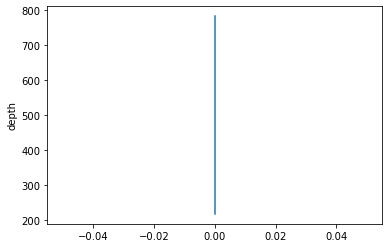

In [12]:
(filt.CT_whole - filt.CT_part).plot(y='depth')

This is strange. Proving the filter with a different profile (or in this case a different section of the same profile) should return a different filtered signal, right? Also, CT_part should be from depth (100,900) but it looks like closer to (200,800). Additionally, part_mask should be from depth (200,800), but it's not exactly on those lines.

All told, there's a lot to look at here, and I feel like I'm getting no where. Time to move on and circle back with a fresh mind.

### Spice Anomaly

Want to compare Dhruv's method (computing spice based on glider reference temperature) to my method (using the defaults in gsw, then calculating the anomaly). Does removing the mean impact the other metrics we are looking at?

In [13]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

In [25]:
n=0
mean_prof = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
anom_prof = float_r.SPICE.isel(rho_grid=n) - mean_prof

for n in range(1,len(float_r.rho_grid)):
    mean_prof      = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
    anom_prof_next = float_r.SPICE.isel(rho_grid=n) - mean_prof

    anom_prof = xr.concat([anom_prof, anom_prof_next], dim='rho_grid')

In [26]:
alpha = gsw.alpha(float_r.SA, float_r.CT, float_r.PRES_INTERPOLATED)

dCT = float_r.CT - float_r.CT.mean('N_PROF_NEW')
float_r['spice']= 2*1000*alpha*dCT

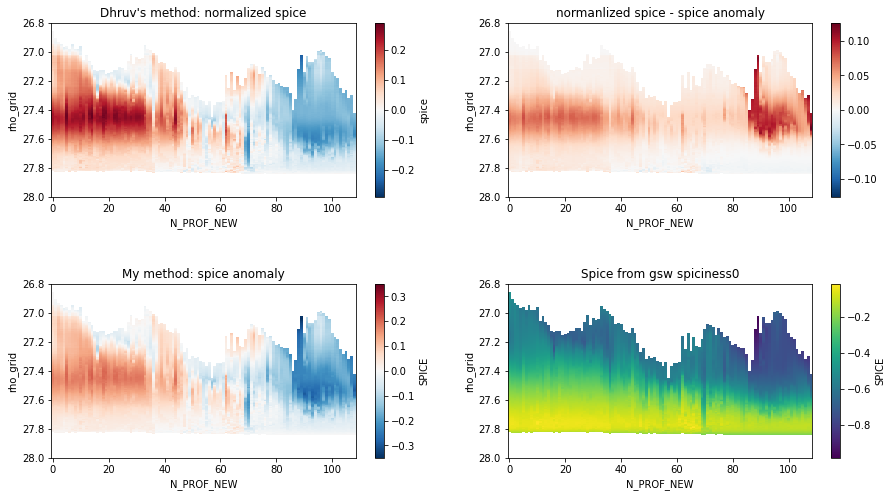

In [29]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_r.spice.plot()
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
(float_r.spice - anom_prof).plot()
plt.gca().invert_yaxis()
plt.title("normanlized spice - spice anomaly")

plt.subplot(2,2,3)
anom_prof.plot()
plt.gca().invert_yaxis()
plt.title("My method: spice anomaly")

plt.subplot(2,2,4)
float_r.SPICE.plot()
plt.gca().invert_yaxis()
plt.title("Spice from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)